In [10]:
import pandas as pd
from datetime import datetime, date
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd
import openpyxl as excel
import glob
import cgmquantify as cgm

import warnings
warnings.filterwarnings('ignore')

In [11]:
path = r'C:\Users\arsal\OneDrive\Desktop\OPEN\EPI-GV\glucose'

extension = 'csv'
os.chdir(path)

files = [i for i in glob.glob('*.{}'.format(extension))]

for f in files:
    p = os.path.join(path, f)
    df = pd.read_csv(p, index_col=None, na_values=" null")
    df.columns = ['Timestamp', 'glucose']
    df["Timestamp"] = df["Timestamp"].replace(regex={r'T': ' ', "Z": ''})
    df.index = pd.to_datetime(df["Timestamp"], format='%Y-%m-%d %H:%M:%S')
    print("\n %s" % f)
    df = df.head(13975)
    #print(df)
    df.to_csv('%s' % f, index=False)


 12345678_entries_2021-10-26_to_2021-11-28.json.csv

 12345678_entries_2022-01-05_to_2022-02-02.json.csv


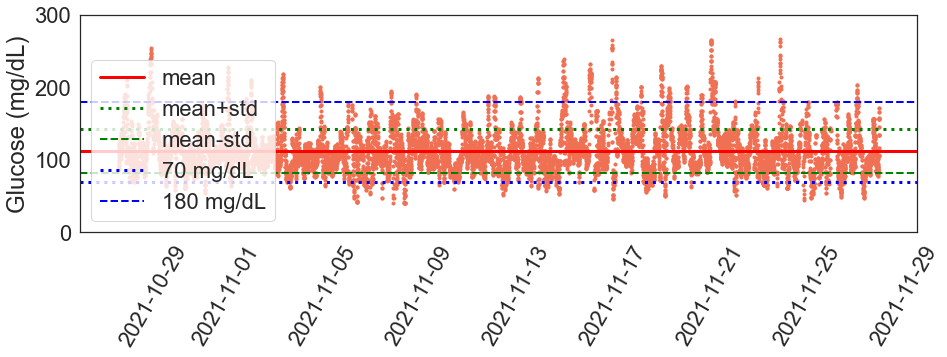

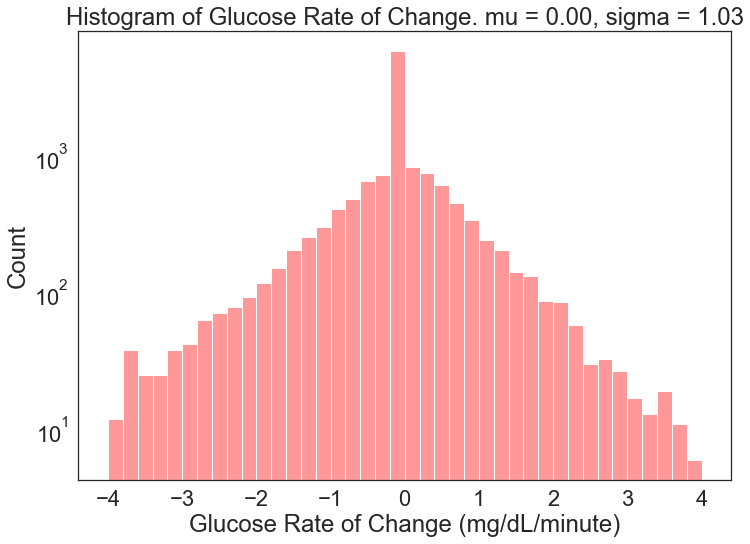

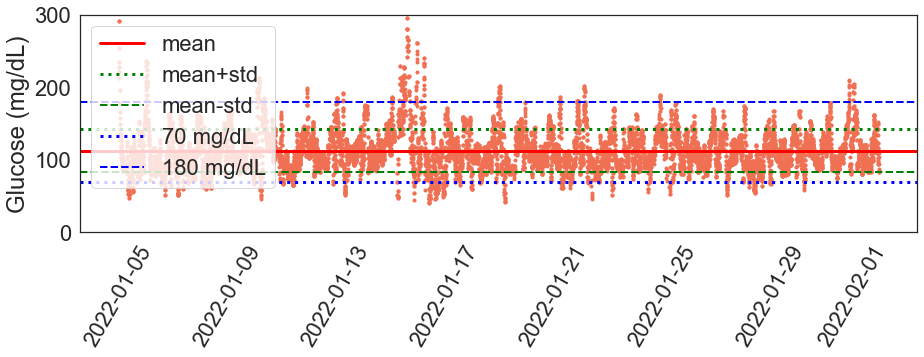

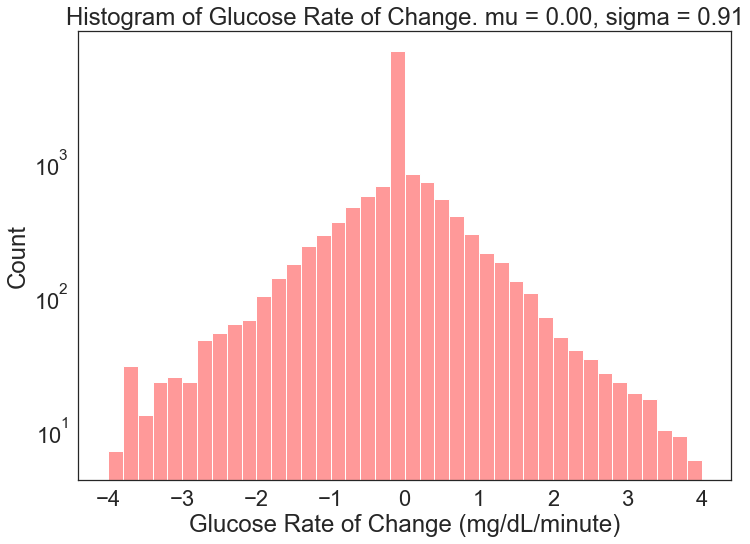

In [18]:
# metrics

TORless70, TIR, TORmore180, stdd, POR, J_index, LBGI, HBGI, GMI = (
    [] for i in range(9))

all_entries_path, all_entries_describe, interdaysd, interdaycv, bg_roc_stds, bg_roc_means = (
    [] for i in range(6))

i = 0

for f in files:
    p = os.path.join(path, f)
    all_entries_path.append(
        p)  # saving all entries file paths in var 'all_entries_path'

    # reading and processing files
    entries = pd.read_csv(p, index_col=None, na_values=" null")
    entries = entries.rename(columns={
        'Timestamp': 'Time',
        'glucose': 'Glucose'
    })
    entries.index = pd.to_datetime(entries["Time"], format='%Y-%m-%d %H:%M:%S')

    #remove duplicate indexes
    entries = entries[~entries.index.duplicated(keep='first')]

    # Replace infinite updated data with nan
    entries.replace([np.inf, -np.inf], np.nan, inplace=True)
    # Drop rows with NaN
    entries.dropna(inplace=True)

    entries = entries[entries['Glucose'].astype(int) >
                      39]  # remove everything less than 39
    entries = entries[entries['Glucose'].astype(int) <
                      1000]  # remove everything greater than 40
    entries['Glucose'].values[
        entries['Glucose'] >
        400] = 400  # anything greater than 400 replace with 400

    # saving statistics of entries files in a list 'male_entries_describe'
    all_entries_describe.append(entries.describe().transpose())

    # calculate TIR and TOR ranges
    ranges = [0, 54, 70, 180, 400]
    entries['ranges'] = pd.cut(entries['Glucose'], bins=ranges)
    result = (entries.groupby([pd.Grouper(key="Time"), "ranges"
                               ])["ranges"].count().unstack(0).T.fillna(0))

    summed_results = result.sum()

    # calculating CGM Metrics
    interdaysd.append(str(cgm.interdaysd(entries)))
    interdaycv.append(str(cgm.interdaycv(entries)))

    TORless70.append(
        float(round(summed_results.iloc[0] / summed_results.sum() * 100, 2)))

    TIR.append(
        float(round(summed_results.iloc[1] / summed_results.sum() * 100, 2)))

    TORmore180.append(
        float(round(summed_results.iloc[2] / summed_results.sum() * 100, 2)))

    POR.append(str(cgm.POR(entries)))
    J_index.append(str(cgm.J_index(entries)))
    LBGI.append(str(cgm.LBGI(entries)))
    HBGI.append(str(cgm.HBGI(entries)))
    GMI.append(str(cgm.GMI(entries)))

    # calculate BG rate of change
    entries['Glucose Rate of Change'] = entries['Glucose'].diff() / 5

    bg_roc_std = entries['Glucose Rate of Change'].std()
    bg_roc_mean = entries['Glucose Rate of Change'].mean()

    bg_roc_stds.append(float(bg_roc_std))
    bg_roc_means.append(float(bg_roc_mean))

    # Plot Entries
    # Calculate the mean and standard deviation of glucose.
    glucose_mean = np.mean(entries['Glucose'])
    up = np.mean(entries['Glucose']) + np.std(entries['Glucose'])
    dw = np.mean(entries['Glucose']) - np.std(entries['Glucose'])

    # Designate a figure size and font size
    plt.figure(figsize=(15, 4))
    plt.rcParams.update({'font.size': 14})
    plt.ylim(0, 300)
    # Plot
    plt.plot(entries['Glucose'], '.', color='#F07054')

    # Plot horizontal lines
    plt.axhline(y=glucose_mean,
                color='red',
                linestyle='-',
                linewidth=3,
                label='mean')
    plt.axhline(y=up,
                color='green',
                linestyle='dotted',
                linewidth=3,
                label='mean+std')
    plt.axhline(y=dw,
                color='green',
                linestyle='dashed',
                linewidth=2,
                label='mean-std')

    plt.xticks(rotation=60)

    plt.axhline(y=70,
                color='blue',
                linestyle='dotted',
                linewidth=3,
                label='70 mg/dL')
    plt.axhline(y=180,
                color='blue',
                linestyle='dashed',
                linewidth=2,
                label='180 mg/dL')
    plt.legend()
    plt.ylabel('Glucose (mg/dL)')

    plt.show()

    i = i + 1

    sns.set(rc={'figure.figsize': (11.7, 8.27)})
    sns.set(font_scale=2)
    sns.set_style(style='white')

    if i == 0:
        # Plot BG Rate of Change
        sns.histplot(data=entries,
                     x='Glucose Rate of Change',
                     binwidth=0.2,
                     alpha=0.4,
                     log_scale=(False, True),
                     binrange=(-4, 4))
        plt.xlabel('Glucose Rate of Change (mg/dL/minute)')
        plt.show()
    else:
        # Plot BG Rate of Change
        sns.histplot(data=entries,
                     x='Glucose Rate of Change',
                     color="red",
                     binwidth=0.2,
                     alpha=0.4,
                     log_scale=(False, True),
                     binrange=(-4, 4))
        plt.title(
            f'Histogram of Glucose Rate of Change. mu = {bg_roc_mean:.2f}, sigma = {bg_roc_std:.2f}'
        )

        plt.xlabel('Glucose Rate of Change (mg/dL/minute)')
        plt.show()

In [19]:
all_stats1 = pd.DataFrame({
    'interdaysd': interdaysd,
    'interdaycv': interdaycv,
    'bg_roc_stds': bg_roc_stds,
    'TOR<70 [%]': TORless70,
    'TIR [%]': TIR,
    'TOR>180 [%]': TORmore180,
    'POR': POR,
    'J_index': J_index,
    'LGBI': LBGI,
    'HBGI': HBGI,
    'GMI': GMI
})  

all_stats2 = pd.concat(all_entries_describe)  # convert statistics to dataframe
all_stats2.reset_index(drop=True, inplace=True)

summarised_statistics = pd.concat([all_stats1, all_stats2], axis=1)

summarised_statistics = summarised_statistics.apply(pd.to_numeric)

summarised_statistics['count'] = summarised_statistics['count'].astype(int)
summarised_statistics['min'] = summarised_statistics['min'].astype(int)
summarised_statistics['25%'] = summarised_statistics['25%'].astype(int)
summarised_statistics['50%'] = summarised_statistics['50%'].astype(int)
summarised_statistics['75%'] = summarised_statistics['75%'].astype(int)
summarised_statistics['max'] = summarised_statistics['max'].astype(int)

pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:,.2f}".format

#summarised_statistics.to_csv(os.path.join(path, "summarised_statistics.csv"))

summarised_statistics

,interdaysd,interdaycv,bg_roc_stds,TOR<70 [%],TIR [%],TOR>180 [%],POR,J_index,LGBI,HBGI,GMI,count,mean,std,min,25%,50%,75%,max
0,30.68,27.30,1.03,0.56,3.55,92.12,24.31,20.47,1.34,1.02,6.00,13817,112.38,30.68,40,92,107,127,267
1,29.28,25.92,0.91,0.68,3.16,93.70,25.10,20.24,1.24,0.94,6.01,13962,112.98,29.28,40,94,108,128,324
